# Model Prediction with Neural Network

In [30]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import os
from PIL import Image 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [31]:
# Read data we collected in the 2nd step
df = pd.read_csv('./turing_dataset/processed_metadata.csv',  encoding='utf-8')
df.head()

,filename,a_u,b_u,c_u,d_u,D_u,F_max,a_v,b_v,c_v,d_v,D_v,G_max,initial_u,initial_v
0,./turing_dataset/pattern_5e6a20f6-3ec6-4ebe-85...,0.020429,0.020245,0.068584,-0.077554,0.025135,0.208119,0.079084,0.493664,0.115691,-0.001345,-0.130253,0.498706,['random_noise' 'triangles' 'spirals'],['sine_wave' 'spirals' 'stripes' 'random_noise...
1,./turing_dataset/pattern_3d823de1-9c51-4043-b9...,0.040340,0.015841,0.061679,-0.092339,0.033879,0.216815,0.086136,0.499560,0.101326,-0.015062,-0.168893,0.497401,['triangles' 'ellipses'],['stripes' 'perlin_noise' 'ellipses' 'triangles']
2,./turing_dataset/pattern_ce1daada-0027-4293-8f...,0.031140,0.018297,0.070244,-0.095640,0.047506,0.199861,0.084112,0.517046,0.089910,-0.016683,-0.165138,0.488055,['sine_wave' 'spirals' 'triangles' 'checkerboa...,['sine_wave' 'checkerboard']
3,./turing_dataset/pattern_5c66337e-e5b4-4f86-91...,0.011838,0.016432,0.096501,-0.067550,0.029620,0.202844,0.064877,0.499388,0.091030,0.017347,-0.160334,0.495626,['grid' 'stripes' 'gaussian_spots' 'circles' '...,['triangles' 'ellipses' 'gaussian_spots' 'spir...
4,./turing_dataset/pattern_ce3daa7d-1f0e-477f-81...,0.027987,0.036642,0.067677,-0.085520,0.017359,0.205186,0.079010,0.500444,0.101256,0.019337,-0.142630,0.518971,['spirals' 'circles' 'grid' 'random_noise' 'si...,['gaussian_spots' 'ellipses' 'sine_wave' 'spir...


In [32]:
df.shape

(2048, 15)

In [33]:
# Get model_parameters and initial conditions of each pattern
model_parameters = df.iloc[:, 1:13].to_numpy()
def process_initial(str):
    str = str[1: -1]
    str_list = str.split()
    str_list = [str[1: -1] for str in str_list]
    return str_list


initial_u = df['initial_u'].apply(process_initial)
initial_v = df['initial_v'].apply(process_initial)

In [34]:
# Generate multi-label one-hot vectors
mlb = MultiLabelBinarizer()
one_hot_encoded_u = mlb.fit_transform(initial_u)
one_hot_encoded_v = mlb.fit_transform(initial_v)

In [35]:
one_hot_encoded_u

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
one_hot_encoded_u.shape

(2048, 11)

In [37]:
# Load data
def load_dataset(folder_path):
    origin_images = []
    images = []
    paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)

            img = Image.open(file_path)
            img = img.resize((100, 100))  # Ensure the image size is 100x100
            data = np.array(img)
            if data.shape[2] == 4:
                data = data[:, :, :3]
            
            origin_images.append(data)

            img = img.convert('L')  # Convert image to grayscale
            images.append(np.array(img))

            paths.append(file_path)
    return np.array(images), paths, np.array(origin_images)

dataset_path = './turing_dataset'

# Extract features
imgs, paths, ori_imgs = load_dataset(dataset_path)
img_index = np.arange(imgs.shape[0])

print("Shape of the dataset:", imgs.shape)

Shape of the dataset: (2048, 100, 100)


In [38]:
# Combine labels
img_labels = np.concatenate([model_parameters,one_hot_encoded_u, one_hot_encoded_v], axis=1)
img_labels.shape

(2048, 34)

In [39]:
# Get train and test dataset
X = imgs.reshape((2048, 1, 100, 100))
X = X / 255.0
y = img_labels

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
# Construct a CNN model
class MultiTaskCNNModel(nn.Module):
    def __init__(self):
        super(MultiTaskCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        
        self.fc_params = nn.Linear(512, 12)
        self.fc_initial = nn.Linear(512, 22)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        
        params_out = self.fc_params(x)
        initial_out = self.fc_initial(x)  # Linear output for CrossEntropyLoss
        
        return params_out, initial_out

model = MultiTaskCNNModel()
criterion_params = nn.MSELoss()
criterion_initial = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Train Loss: 0.6647, Test Loss: 0.5798
Epoch [2/10], Train Loss: 0.6009, Test Loss: 0.5755
Epoch [3/10], Train Loss: 0.5882, Test Loss: 0.5761
Epoch [4/10], Train Loss: 0.5864, Test Loss: 0.5748
Epoch [5/10], Train Loss: 0.5811, Test Loss: 0.5747
Epoch [6/10], Train Loss: 0.5849, Test Loss: 0.5756
Epoch [7/10], Train Loss: 0.5842, Test Loss: 0.5754
Epoch [8/10], Train Loss: 0.5827, Test Loss: 0.5747
Epoch [9/10], Train Loss: 0.5814, Test Loss: 0.5751
Epoch [10/10], Train Loss: 0.5818, Test Loss: 0.5746


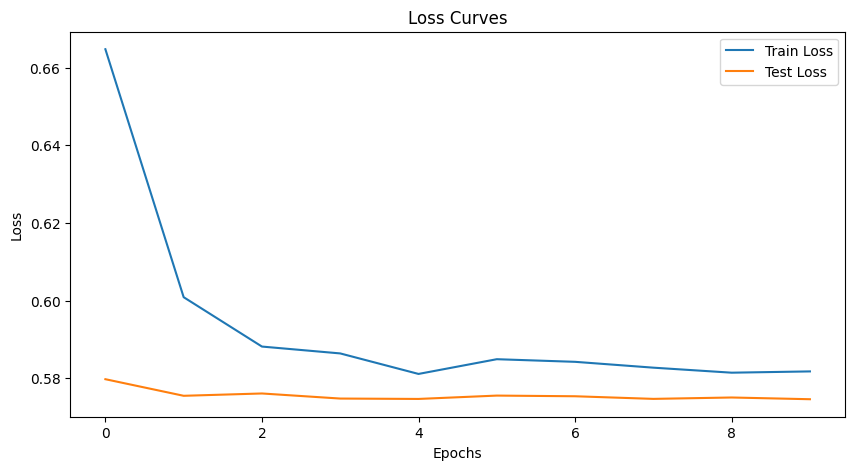

In [41]:
# Train
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        params_out, initial_out = model(inputs)
        params_labels = labels[:, :12]
        initial_labels = labels[:, 12:]
        loss_params = criterion_params(params_out, params_labels)
        loss_initial = criterion_initial(initial_out, initial_labels)
        loss = loss_params + loss_initial
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss/len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            params_labels = labels[:, :12]
            initial_labels = labels[:, 12:]
            params_out, initial_out = model(inputs)
            loss_params = criterion_params(params_out, params_labels)
            loss_initial = criterion_initial(initial_out, initial_labels)
            test_loss += (loss_params + loss_initial).item()
    
    test_losses.append(test_loss/len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()